In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import random

def set_seed(seed):
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [12]:
# Generate Chirikov-Taylor Standard Map data

def standard_map(points, K=0.9):
    """Applies one iteration of the Standard Map."""
    # Input shape: (N, 2) where columns are (theta, p)
    theta_current = points[:, 0]
    p_current = points[:, 1]
    
    p_next = (p_current + K * torch.sin(theta_current)) % (2 * np.pi)
    theta_next = (theta_current + p_next) % (2 * np.pi)
    
    return torch.stack([theta_next, p_next], dim=1)


def generate_standard_map_data(n_trajectories=20, n_steps=50, K=0.9, stable=True):
    """Generates trajectories from a STABLE island of the Standard Map."""
    print("Generating training data from a stable island of the Standard Map...")
    # Initial points are sampled from a stable region near the center
    if stable == True:
        initial_points = torch.rand(n_trajectories, 2) * 0.5 + torch.tensor([np.pi - 0.25, -0.25])
    else:
        initial_points = torch.rand(n_trajectories, 2) * 2 * np.pi

    
    all_trajectories = [initial_points]
    current_points = initial_points
    for _ in range(n_steps - 1):
        current_points = standard_map(current_points, K)
        all_trajectories.append(current_points)
        
    # Shape: (batch, time, dims)

    return torch.stack(all_trajectories, dim=1)

def generate_chaotic_standard_map_data(n_trajectories=20, n_steps=50, K=2.0, stable=False):
    """Generates trajectories from the CHAOTIC sea of the Standard Map."""
    print(f"Generating training data from the chaotic sea of the Standard Map with K={K}...")
    # Initial points are sampled randomly across the entire phase space
    if stable == True:
        initial_points = torch.rand(n_trajectories, 2) * 0.5 + torch.tensor([np.pi - 0.25, -0.25])
    else:
        initial_points = torch.rand(n_trajectories, 2) * 2 * np.pi

    all_trajectories = [initial_points]
    current_points = initial_points
    for _ in range(n_steps - 1):
        # We can reuse the same standard_map function
        current_points = standard_map(current_points, K)
        all_trajectories.append(current_points)
        
    return torch.stack(all_trajectories, dim=1)

Generating training data from a stable island of the Standard Map...


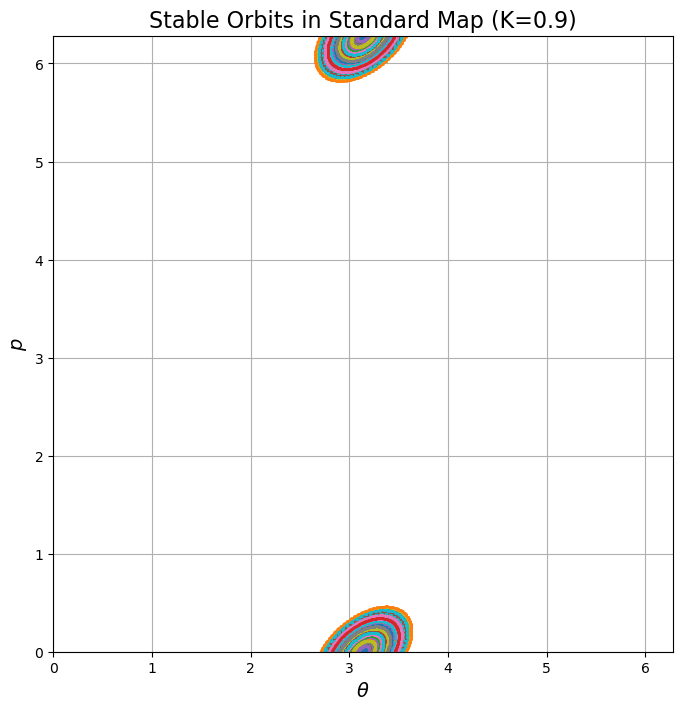

Generating training data from the chaotic sea of the Standard Map with K=2.0...


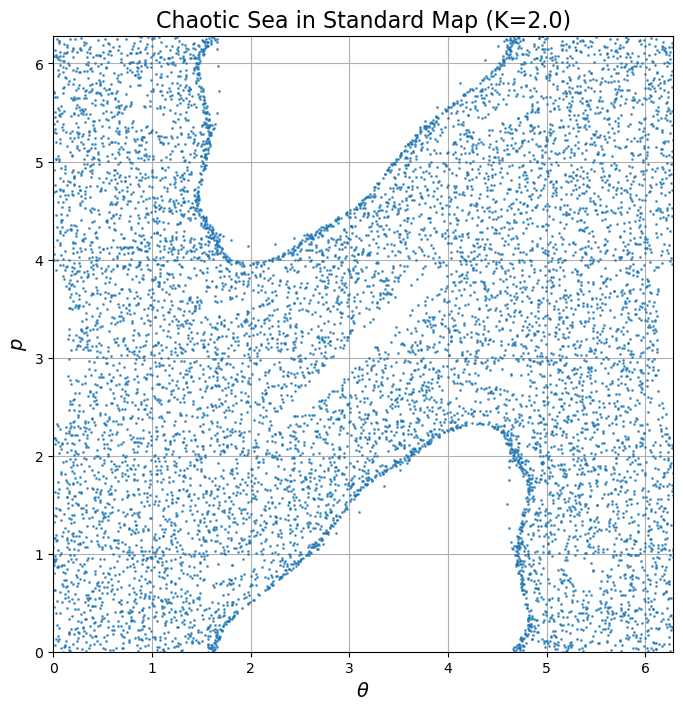

In [7]:
import matplotlib.pyplot as plt

# --- Visualization Code ---
def visualize_trajectories(trajectories, title):
    """Plots the generated trajectories in the phase space."""
    # Convert to numpy for plotting
    data = trajectories.numpy()
    
    # Get dimensions
    n_trajectories = data.shape[0]
    
    plt.figure(figsize=(8, 8))
    # Plot each trajectory with a different color
    for i in range(n_trajectories):
        plt.plot(data[i, :, 0], data[i, :, 1], 'o', markersize=1, alpha=0.7)
        
    plt.title(title, fontsize=16)
    plt.xlabel(r'$\theta$', fontsize=14)
    plt.ylabel(r'$p$', fontsize=14)
    plt.xlim(0, 2 * np.pi)
    plt.ylim(0, 2 * np.pi)
    plt.grid(True)
    plt.show()

# --- Generate and Plot ---

# 1. Stable Data (K < 0.97)
# For visualization, let's generate longer trajectories
stable_trajectories = generate_standard_map_data(n_trajectories=1000, n_steps=500, K=0.9)
visualize_trajectories(stable_trajectories, "Stable Orbits in Standard Map (K=0.9)")

# 2. Chaotic Data (K > 0.97)
chaotic_trajectories = generate_chaotic_standard_map_data(n_trajectories=1, n_steps=10000, K=2.0)
visualize_trajectories(chaotic_trajectories, "Chaotic Sea in Standard Map (K=2.0)")

In [18]:
from tqdm import tqdm

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=n_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, sequence_length, hidden_dim)
        output = self.fc(lstm_out)
        return output
    
def train_model(model, data, epochs=200, lr=0.005):
    """
    Trains the RNN model on GPU if available, then returns it to CPU.
    """
    # 1. 장치 설정 및 모델을 GPU로 이동
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"--- Starting training on {device} ---")

    # 데이터 준비
    X_train = data[:, :-1, :].to(device)
    y_train = data[:, 1:, :].to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # ... (학습 루프는 동일) ...
    pbar = tqdm(range(epochs), desc="Training Progress")
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 20 == 0:
            pbar.set_postfix({'Epoch': epoch+1, 'Loss': f'{loss.item():.6f}'})

    print("Training finished.")

    # 2. 모델을 다시 CPU로 이동
    model.to('cpu')
    print("--- Model moved back to CPU for analysis ---")
    
    return model

In [15]:
def validate_and_plot(model, ground_truth_data, n_steps_to_generate=1000, title=""):
    """Generates a trajectory from the trained model and plots it against the ground truth."""
    model.eval()
    with torch.no_grad():
        # 첫 번째 궤적의 시작점을 초기점으로 사용
        initial_point = ground_truth_data[0:1, 0:1, :] # Shape: (1, 1, 2)
        
        # 모델로부터 자율적으로 궤적 생성
        generated_trajectory = [initial_point.squeeze(1)]
        current_point = initial_point
        
        for _ in range(n_steps_to_generate - 1):
            next_point = model(current_point)
            generated_trajectory.append(next_point.squeeze(1))
            current_point = next_point

    generated_trajectory = torch.cat(generated_trajectory, dim=0).numpy()
    ground_truth_trajectory = ground_truth_data[0].numpy()

    plt.figure(figsize=(10, 5))
    
    # Ground Truth Attractor
    plt.subplot(1, 2, 1)
    plt.plot(ground_truth_trajectory[:, 0], ground_truth_trajectory[:, 1], 'o', color='gray', markersize=1, label='Ground Truth')
    plt.title("Ground Truth Attractor")
    plt.xlabel(r'$\theta$'); plt.ylabel(r'$p$')
    plt.xlim(0, 2 * np.pi); plt.ylim(0, 2 * np.pi)
    plt.grid(True)

    # Learned Attractor
    plt.subplot(1, 2, 2)
    plt.plot(generated_trajectory[:, 0], generated_trajectory[:, 1], 'o', color='blue', markersize=1, label='Learned')
    plt.title("Learned Attractor")
    plt.xlabel(r'$\theta$'); plt.ylabel(r'$p$')
    plt.xlim(0, 2 * np.pi); plt.ylim(0, 2 * np.pi)
    plt.grid(True)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [29]:
import torch
import numpy as np
from tqdm import tqdm
import time

# 이 함수는 이전 코드의 calculate_mle 함수를 대체합니다.
def calculate_mle(model, n_steps=2000, n_warmup=500):
    """
    Calculates the MLE for a given model on GPU, disabling cuDNN for JVP calculation.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() # 기본 모드는 평가 모드
    print(f"Calculating MLE on {device}...")
    
    num_layers = model.lstm.num_layers
    hidden_dim = model.lstm.hidden_size
    input_dim = model.lstm.input_size
    
    v = torch.randn(num_layers, 1, hidden_dim).to(device)
    v = v / torch.norm(v)

    h = torch.zeros(num_layers, 1, hidden_dim).to(device)
    c = torch.zeros(num_layers, 1, hidden_dim).to(device)
    
    warmup_input = torch.randn(1, n_warmup, input_dim).to(device)
    with torch.no_grad():
        _, (h, c) = model.lstm(warmup_input, (h, c))

    lyap_exponents = []
    
    pbar = tqdm(range(n_steps), desc="MLE Calculation")
    for _ in pbar:
        def lstm_step_func(h_in, c_in):
            dummy_input = torch.zeros(1, 1, input_dim).to(device)
            _, (h_out, c_out) = model.lstm(dummy_input, (h_in, c_in))
            return h_out

        # JVP 계산 부분을 with 블록으로 감쌉니다.
        with torch.backends.cudnn.flags(enabled=False):
            # 이전 오류 해결을 위한 train() 모드 전환은 유지합니다.
            model.train()
            _, jvp_h = torch.autograd.functional.jvp(
                lambda h_in: lstm_step_func(h_in, c), 
                (h), 
                (v)
            )
            model.eval()

        divergence = torch.norm(jvp_h)
        lyap_exponents.append(torch.log(divergence).item())

        with torch.no_grad():
             dummy_input = torch.zeros(1, 1, input_dim).to(device)
             _, (h, c) = model.lstm(dummy_input, (h, c))
        v = jvp_h / divergence
        
    mle = np.mean(lyap_exponents)
    return mle

Generating training data from a stable island of the Standard Map...
--- Starting training on cuda ---


Training Progress: 100%|██████████| 3000/3000 [02:51<00:00, 17.51it/s, Epoch=3000, Loss=0.067397]


Training finished.
--- Model moved back to CPU for analysis ---
Generating training data from a stable island of the Standard Map...
--- Starting training on cuda ---


Training Progress: 100%|██████████| 3000/3000 [02:47<00:00, 17.92it/s, Epoch=3000, Loss=0.081855]


Training finished.
--- Model moved back to CPU for analysis ---

--- Validating Stable Model ---
Generating training data from a stable island of the Standard Map...


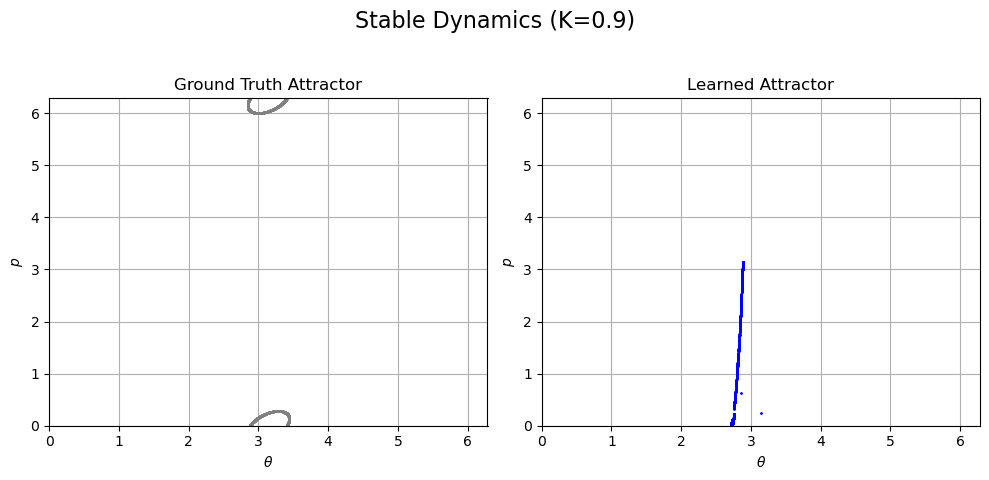


--- Validating Chaotic Model ---
Generating training data from a stable island of the Standard Map...


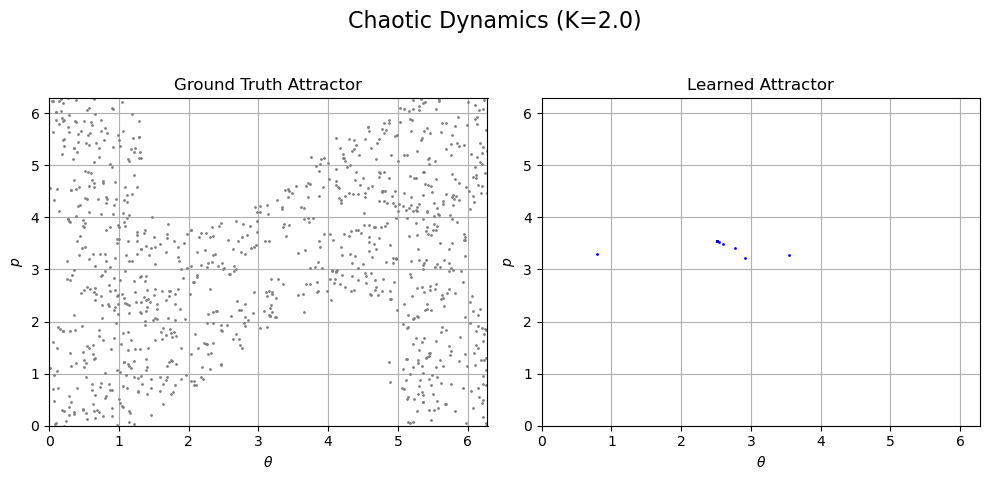

In [19]:
# 하이퍼파라미터 설정
N_TRAJECTORIES = 1000
N_STEPS = 1000
INPUT_DIM = 2
HIDDEN_DIM = 64  # 은닉 유닛 수 (모델 크기)
OUTPUT_DIM = 2
N_LAYERS = 2
EPOCHS = 3000
LEARNING_RATE = 0.005

# 1. 안정적인 모델 학습
stable_data = generate_standard_map_data(N_TRAJECTORIES, N_STEPS, K=0.9, stable=True)
model_stable = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS)
model_stable = train_model(model_stable, stable_data, epochs=EPOCHS, lr=LEARNING_RATE)

# 2. 카오스 모델 학습
chaotic_data = generate_standard_map_data(N_TRAJECTORIES, N_STEPS, K=2.0, stable=False)
model_chaotic = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS)
model_chaotic = train_model(model_chaotic, chaotic_data, epochs=EPOCHS, lr=LEARNING_RATE)

# 3. 결과 검증
print("\n--- Validating Stable Model ---")
# 검증용 긴 궤적 데이터 생성
validation_stable_data = generate_standard_map_data(1, 1000, K=0.9, stable=True)
validate_and_plot(model_stable, validation_stable_data, n_steps_to_generate=1000, title="Stable Dynamics (K=0.9)")

print("\n--- Validating Chaotic Model ---")
# 검증용 긴 궤적 데이터 생성
validation_chaotic_data = generate_standard_map_data(1, 1000, K=2.0, stable=False)
validate_and_plot(model_chaotic, validation_chaotic_data, n_steps_to_generate=1000, title="Chaotic Dynamics (K=2.0)")

In [30]:

# --- 안정적인 모델에 대한 MLE 계산 ---
start_time = time.time()
mle_stable = calculate_mle(model_stable)
end_time = time.time()
time_stable = end_time - start_time
print(f"MLE for STABLE model: {mle_stable:.6f}")
print(f"Calculation time: {time_stable:.2f} seconds\n")

# --- 카오스 모델에 대한 MLE 계산 ---
start_time = time.time()
mle_chaotic = calculate_mle(model_chaotic)
end_time = time.time()
time_chaotic = end_time - start_time
print(f"MLE for CHAOTIC model: {mle_chaotic:.6f}")
print(f"Calculation time: {time_chaotic:.2f} seconds\n")

# --- 최종 결과 요약 ---
print("--- MLE Calculation Summary ---")
print(f"Model trained on stable data (K=0.9): MLE = {mle_stable:.6f} (Expected <= 0)")
print(f"Model trained on chaotic data (K=2.0): MLE = {mle_chaotic:.6f} (Expected > 0)")

Calculating MLE on cuda...


MLE Calculation: 100%|██████████| 2000/2000 [00:05<00:00, 394.94it/s]


MLE for STABLE model: -0.116622
Calculation time: 5.07 seconds

Calculating MLE on cuda...


MLE Calculation: 100%|██████████| 2000/2000 [00:04<00:00, 437.27it/s]

MLE for CHAOTIC model: -0.545836
Calculation time: 4.58 seconds

--- MLE Calculation Summary ---
Model trained on stable data (K=0.9): MLE = -0.116622 (Expected <= 0)
Model trained on chaotic data (K=2.0): MLE = -0.545836 (Expected > 0)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===================================================================
# STEP 1: 데이터 생성 및 변환
# ===================================================================

def standard_map(points, K=0.9):
    """Standard Map의 한 스텝을 적용합니다."""
    # points shape: (N, 2), columns: (theta, p)
    theta_current = points[:, 0]
    p_current = points[:, 1]
    
    p_next = (p_current + K * torch.sin(theta_current)) % (2 * np.pi)
    theta_next = (theta_current + p_next) % (2 * np.pi)
    
    return torch.stack([theta_next, p_next], dim=1)

def generate_angle_data(n_trajectories, n_steps, K, stable=True):
    """Standard Map으로부터 각도(theta, p) 시계열 데이터를 생성합니다."""
    if stable:
        # 안정적인 섬 내부에서 초기점 샘플링
        initial_points = torch.rand(n_trajectories, 2) * 0.5 + torch.tensor([np.pi - 0.25, -0.25])
    else:
        # 위상 공간 전체에서 무작위 샘플링
        initial_points = torch.rand(n_trajectories, 2) * 2 * np.pi

    trajectories = [initial_points]
    current_points = initial_points
    for _ in range(n_steps - 1):
        current_points = standard_map(current_points, K)
        trajectories.append(current_points)
        
    return torch.stack(trajectories, dim=1)

def convert_to_trig_data(angle_data):
    """각도 데이터를 (cos, sin) 형태로 변환합니다."""
    # angle_data shape: (batch, seq, 2)
    cos_theta = torch.cos(angle_data[:, :, 0])
    sin_theta = torch.sin(angle_data[:, :, 0])
    cos_p = torch.cos(angle_data[:, :, 1])
    sin_p = torch.sin(angle_data[:, :, 1])
    # output shape: (batch, seq, 4)
    return torch.stack([cos_theta, sin_theta, cos_p, sin_p], dim=2)

# ===================================================================
# STEP 2: Toroidal LSTM 모델 정의
# ===================================================================

class ToroidalLSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=4, n_layers=2):
        super(ToroidalLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layers,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x, states=None):
        lstm_out, (h, c) = self.lstm(x, states)
        trig_output = self.fc(lstm_out)
        return trig_output, (h, c)

# ===================================================================
# STEP 3: 분석 도구 함수
# ===================================================================

def run_homological_analysis_lstm(model, device: torch.device, n_points: int = 2000) -> float:
    model.to(device)
    model.eval()
    
    start_time = time.perf_counter()

    # 1. 2D 토러스의 기본 루프 생성 (각도 공간)
    t = torch.linspace(0, 2 * np.pi, n_points, device=device)
    loop1_angle = torch.stack([t, torch.zeros_like(t)], dim=1)
    loop2_angle = torch.stack([torch.zeros_like(t), t], dim=1)
    basis_loops_angle = [loop1_angle, loop2_angle]

    # 2. LSTM 모델을 통해 루프를 한 스텝 변환
    transformed_loops_angle = []
    with torch.no_grad():
        for loop_angle in basis_loops_angle:
            # 루프를 (cos, sin) 형태로 변환하여 모델 입력으로 준비
            loop_trig = torch.stack([
                torch.cos(loop_angle[:, 0]), torch.sin(loop_angle[:, 0]),
                torch.cos(loop_angle[:, 1]), torch.sin(loop_angle[:, 1])
            ], dim=1).unsqueeze(0) # (1, n_points, 4)
            
            # 모델을 통해 변환된 궤적(trig)을 얻음
            transformed_trig, _ = model(loop_trig)
            
            # 결과를 다시 각도(theta, p)로 변환
            cos1, sin1, cos2, sin2 = transformed_trig.squeeze(0).T
            theta_out = torch.atan2(sin1, cos1)
            p_out = torch.atan2(sin2, cos2)
            transformed_loops_angle.append(torch.stack([theta_out, p_out], dim=1).cpu())
            
    # 3. 호몰로지 행렬 계산 (이전과 동일)
    matrix = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops_angle):
        unwrapped = np.unwrap(loop.numpy(), axis=0)
        windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        windings_int = np.round(windings).astype(int)
        #assert np.allclose(windings, windings_int, atol=0.1), "Winding number is not close to an integer"
        matrix[:, i] = windings_int
    
    # 4. 고유값 계산 (카오스 진단에 사용)
    eigenvalues = np.linalg.eigvals(matrix)
    
    end_time = time.perf_counter()
    # --- YOUR ANALYSIS LOGIC & TIMING END ---
    
    return end_time - start_time

def calculate_mle_lstm(model: ToroidalLSTM, device: torch.device, n_steps: int = 200) -> float:
    """
    Toroidal LSTM 모델에 대한 MLE 계산 시간을 측정합니다.
    """
    model.to(device)
    model.eval()

    num_layers = model.n_layers
    hidden_dim = model.hidden_dim
    input_dim = model.lstm.input_size

    v = torch.randn(num_layers, 1, hidden_dim).to(device)
    v = v / torch.norm(v)

    h = torch.zeros(num_layers, 1, hidden_dim).to(device)
    c = torch.zeros(num_layers, 1, hidden_dim).to(device)
    
    start_time = time.perf_counter()
    
    for _ in range(n_steps):
        def model_one_step(h_in, c_in):
            dummy_input = torch.zeros(1, 1, input_dim).to(device)
            # 전체 모델(LSTM + FC layer)을 한 스텝으로 간주
            trig_output, (h_out, c_out) = model(dummy_input, (h_in, c_in))
            # 섭동은 내부 은닉 상태 h에 대해 계산
            return h_out

        with torch.backends.cudnn.flags(enabled=False):
            model.train()
            _, jvp_h = torch.autograd.functional.jvp(
                lambda h_in: model_one_step(h_in, c), (h), (v)
            )
            model.eval()

        divergence = torch.norm(jvp_h)
        with torch.no_grad():
            # model_one_step 대신 전체 model을 호출하여 (h, c)를 업데이트합니다.
            dummy_input = torch.zeros(1, 1, model.lstm.input_size).to(device)
            _, (h, c) = model(dummy_input, (h, c))
        v = jvp_h / divergence
            
    end_time = time.perf_counter()
    return end_time - start_time


# ===================================================================
# STEP 4: 실험 실행 및 시각화 (이전과 동일)
# ===================================================================
def run_scalability_experiments():
    """전체 확장성 실험을 조율합니다."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running experiments on: {device}")
    
    WIDTH_TEST_DIMS = [64, 128, 256, 512, 1024, 2048]
    DEPTH_TEST_LAYERS = [2, 4, 8, 16]
    FIXED_DEPTH = 2
    FIXED_WIDTH = 128
    NUM_RUNS = 3 # 시간을 줄이기 위해 3회로 조정
    
    results_log = []

    # --- 너비(Width) 테스트 ---
    print("\n--- Starting Width Scalability Test ---")
    for hidden_dim in WIDTH_TEST_DIMS:
        for run in range(NUM_RUNS):
            print(f"Testing D(internal)={hidden_dim}, Run {run+1}/{NUM_RUNS}...")
            model = ToroidalLSTM(input_dim=4, hidden_dim=hidden_dim, output_dim=4, n_layers=FIXED_DEPTH)
            
            mle_time = calculate_mle_lstm(model, device, n_steps=2000)
            our_time = run_homological_analysis_lstm(model, device)
            
            results_log.append({
                "test_type": "width", "d_model": hidden_dim, "num_layers": FIXED_DEPTH,
                "run": run, "mle_time": mle_time, "our_time": our_time
            })
    
    # --- 깊이(Depth) 테스트 ---
    print("\n--- Starting Depth Scalability Test ---")
    for num_layers in DEPTH_TEST_LAYERS:
        for run in range(NUM_RUNS):
            print(f"Testing L={num_layers}, Run {run+1}/{NUM_RUNS}...")
            model = ToroidalLSTM(input_dim=4, hidden_dim=FIXED_WIDTH, output_dim=4, n_layers=num_layers)

            mle_time = calculate_mle_lstm(model, device)
            our_time = run_homological_analysis_lstm(model, device)

            results_log.append({
                "test_type": "depth", "d_model": FIXED_WIDTH, "num_layers": num_layers,
                "run": run, "mle_time": mle_time, "our_time": our_time
            })
    
    df = pd.DataFrame(results_log)
    df.to_csv("toroidal_scalability_results.csv", index=False)
    print("\nExperiment results saved to toroidal_scalability_results.csv")
    return df

def plot_results(df):
    """Analyzes and plots the results from the experiment dataframe."""
    
    # --- 너비 테스트 결과 시각화 ---
    df_width = df[df['test_type'] == 'width']
    summary_width = df_width.groupby('d_model').agg(
        mle_time_mean=('mle_time', 'mean'), mle_time_std=('mle_time', 'std'),
        our_time_mean=('our_time', 'mean'), our_time_std=('our_time', 'std')
    ).reset_index()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    ax1.errorbar(summary_width['d_model'], summary_width['mle_time_mean'], yerr=summary_width['mle_time_std'],
                 label='Standard MLE', fmt='-o', capsize=5, color='crimson')
    ax1.errorbar(summary_width['d_model'], summary_width['our_time_mean'], yerr=summary_width['our_time_std'],
                 label='Our Method (Proposed)', fmt='-s', capsize=5, color='darkblue')
    ax1.set_xlabel('Hidden Dimension (D)', fontsize=14)
    ax1.set_ylabel('Execution Time (seconds)', fontsize=14)
    ax1.set_title('Scalability vs. Model Width', fontsize=16)
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.legend(fontsize=12); ax1.tick_params(axis='both', which='major', labelsize=12)

    # --- 깊이 테스트 결과 시각화 ---
    df_depth = df[df['test_type'] == 'depth']
    summary_depth = df_depth.groupby('num_layers').agg(
        mle_time_mean=('mle_time', 'mean'), mle_time_std=('mle_time', 'std'),
        our_time_mean=('our_time', 'mean'), our_time_std=('our_time', 'std')
    ).reset_index()
    
    ax2.errorbar(summary_depth['num_layers'], summary_depth['mle_time_mean'], yerr=summary_depth['mle_time_std'],
                 label='Standard MLE', fmt='-o', capsize=5, color='crimson')
    ax2.errorbar(summary_depth['num_layers'], summary_depth['our_time_mean'], yerr=summary_depth['our_time_std'],
                 label='Our Method (Proposed)', fmt='-s', capsize=5, color='darkblue')
    ax2.set_xlabel('Number of Layers (L)', fontsize=14)
    ax2.set_ylabel('Execution Time (seconds)', fontsize=14)
    ax2.set_title('Scalability vs. Model Depth', fontsize=16)
    ax2.set_xscale('linear'); ax2.set_yscale('linear') # 깊이는 선형 스케일이 더 적합
    ax2.legend(fontsize=12); ax2.tick_params(axis='both', which='major', labelsize=12)

    fig.suptitle('Computational Performance a`nalysis', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("scalability_comparison.png", dpi=300)
    plt.show()


Running experiments on: cuda

--- Starting Width Scalability Test ---
Testing D(internal)=64, Run 1/3...
Testing D(internal)=64, Run 2/3...
Testing D(internal)=64, Run 3/3...
Testing D(internal)=128, Run 1/3...
Testing D(internal)=128, Run 2/3...
Testing D(internal)=128, Run 3/3...
Testing D(internal)=256, Run 1/3...
Testing D(internal)=256, Run 2/3...
Testing D(internal)=256, Run 3/3...
Testing D(internal)=512, Run 1/3...
Testing D(internal)=512, Run 2/3...
Testing D(internal)=512, Run 3/3...
Testing D(internal)=1024, Run 1/3...
Testing D(internal)=1024, Run 2/3...
Testing D(internal)=1024, Run 3/3...
Testing D(internal)=2048, Run 1/3...
Testing D(internal)=2048, Run 2/3...
Testing D(internal)=2048, Run 3/3...

--- Starting Depth Scalability Test ---
Testing L=2, Run 1/3...
Testing L=2, Run 2/3...
Testing L=2, Run 3/3...
Testing L=4, Run 1/3...
Testing L=4, Run 2/3...
Testing L=4, Run 3/3...
Testing L=8, Run 1/3...
Testing L=8, Run 2/3...
Testing L=8, Run 3/3...
Testing L=16, Run 1/3.

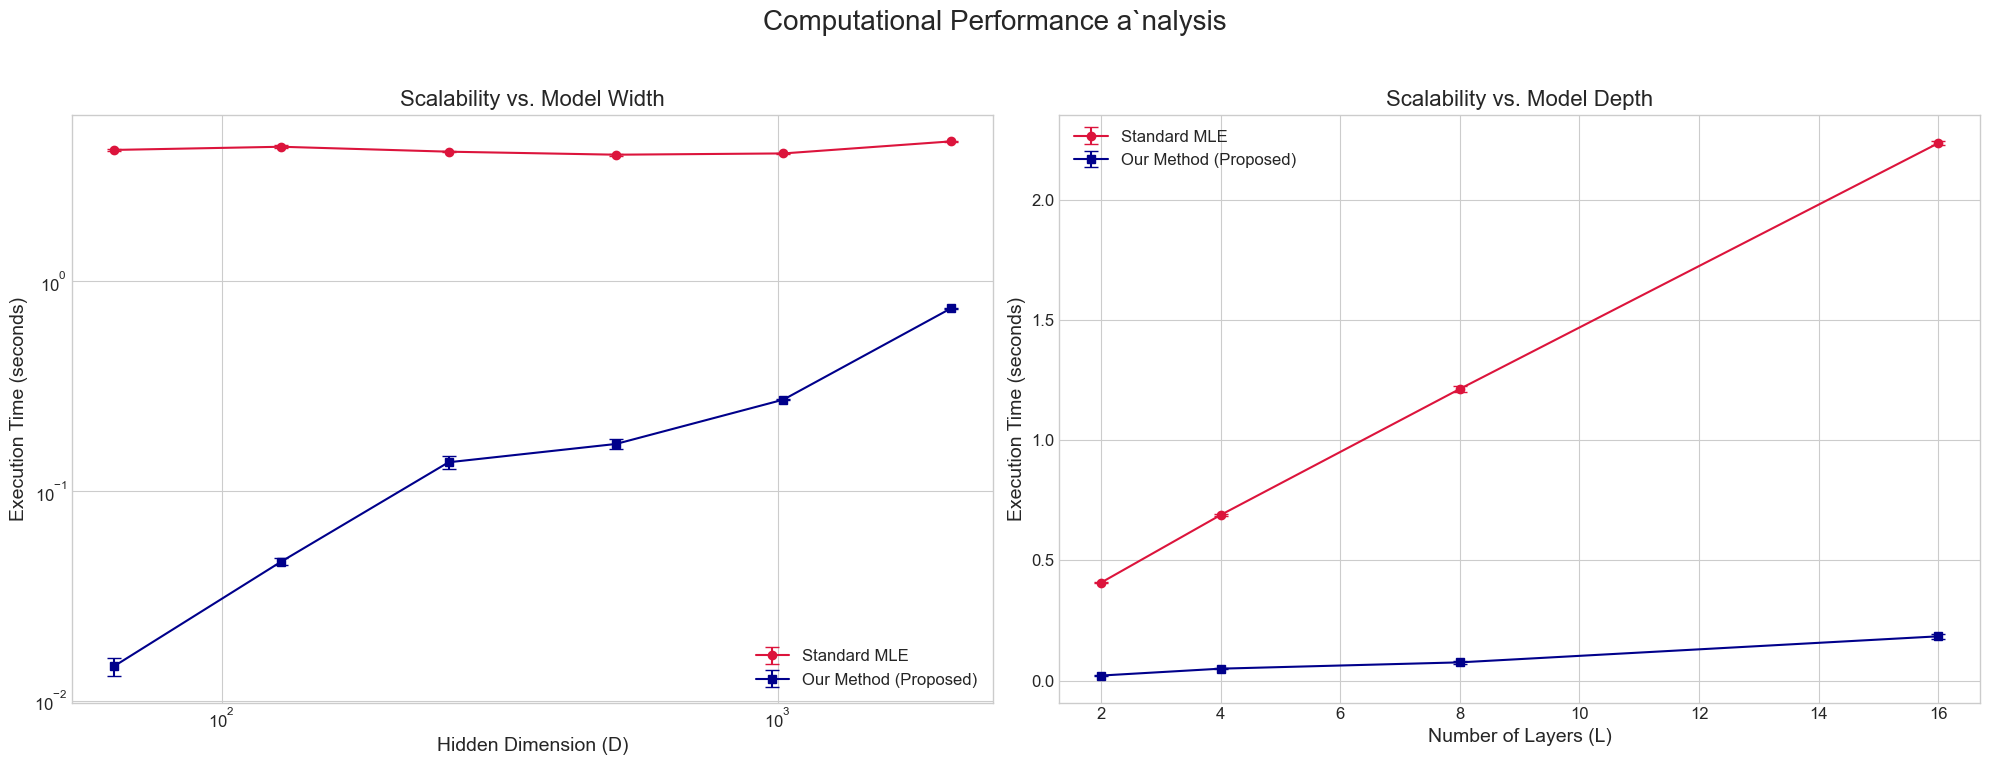

In [44]:
results_df = run_scalability_experiments()
print("\n--- Aggregated Results ---")
print(results_df.groupby(['test_type', 'd_model', 'num_layers']).mean())
plot_results(results_df)

In [45]:
!pip install thop

  Obtaining dependency information for thop from https://files.pythonhosted.org/packages/bb/0f/72beeab4ff5221dc47127c80f8834b4bcd0cb36f6ba91c0b1d04a1233403/thop-0.1.1.post2209072238-py3-none-any.whl.metadata


Using device: cuda
총 35개의 모델 구성으로 실험을 진행합니다.


Running Experiments: 100%|██████████| 35/35 [1:54:42<00:00, 196.64s/it]



--- Experimental Results ---
      Method    Params         FLOPs     Time
0   Homology      4996  5.248000e+06   0.0011
1        MLE      4996  7.872000e+07   5.4038
2   Homology     18180  1.868800e+07   0.0011
3        MLE     18180  2.803200e+08   5.3532
4   Homology     39556  4.032000e+07   0.0011
..       ...       ...           ...      ...
65       MLE   3413764  5.148288e+10  40.4209
66  Homology   6059012  6.083584e+09   0.0936
67       MLE   6059012  9.125376e+10  40.3444
68  Homology  13610500  1.364736e+10   0.1022
69       MLE  13610500  2.047104e+11  41.4157

[70 rows x 4 columns]


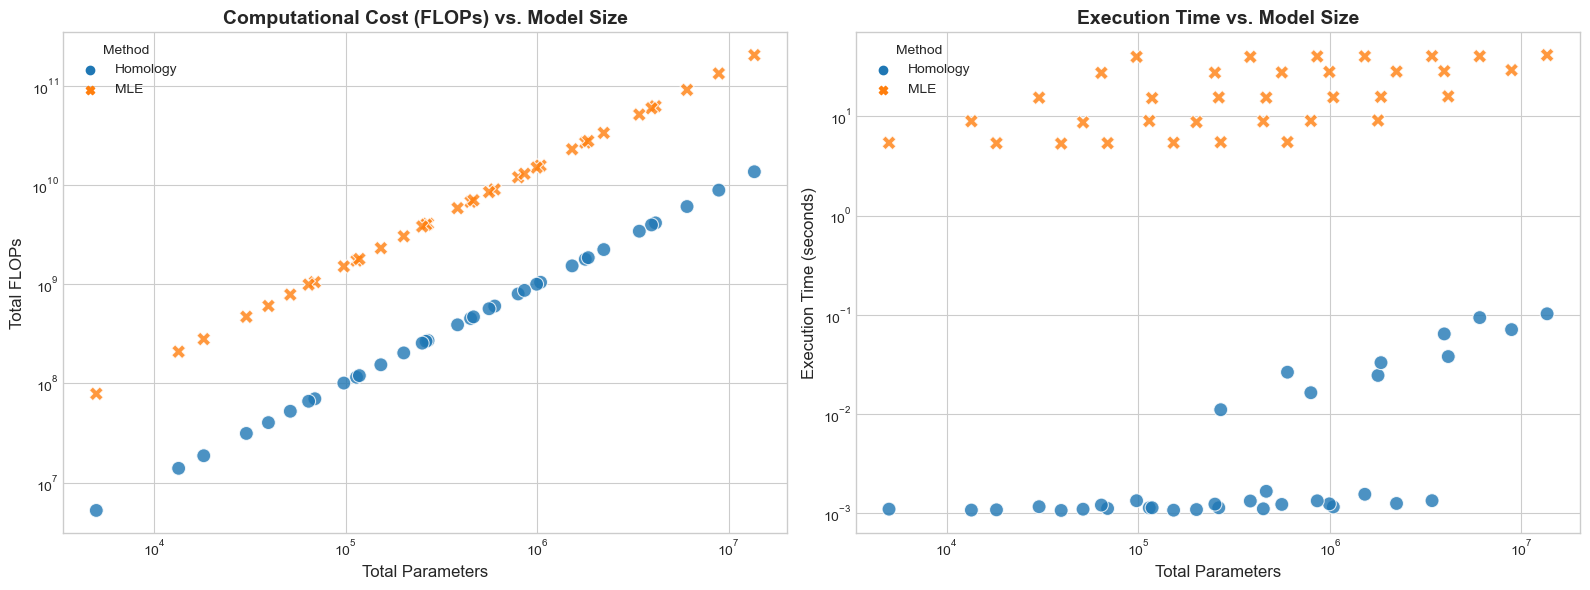

In [46]:
import torch
import torch.nn as nn
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from thop import profile
from tqdm import tqdm
import itertools

# --- 1. 모델 정의 (ToroidalLSTM) ---
class ToroidalLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=2, output_size=4):
        super().__init__()
        # 나중에 참조할 수 있도록 모델 속성 저장
        self.input_dim = input_size
        self.hidden_dim = hidden_size
        self.n_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_c_state=None):
        lstm_out, (h_n, c_n) = self.lstm(x, h_c_state)
        output = self.fc(lstm_out)
        return output, (h_n, c_n)

# --- 2. 분석 함수 정의 ---

def run_homological_analysis_lstm(model: ToroidalLSTM, device: torch.device, n_points: int = 500) -> float:
    model.to(device)
    model.eval()
    
    start_time = time.perf_counter()
    t = torch.linspace(0, 2 * np.pi, n_points, device=device)
    basis_loops_angle = [torch.stack([t, torch.zeros_like(t)], dim=1),
                         torch.stack([torch.zeros_like(t), t], dim=1)]

    with torch.no_grad():
        for loop_angle in basis_loops_angle:
            loop_trig = torch.stack([
                torch.cos(loop_angle[:, 0]), torch.sin(loop_angle[:, 0]),
                torch.cos(loop_angle[:, 1]), torch.sin(loop_angle[:, 1])
            ], dim=1).unsqueeze(0)
            model(loop_trig) # 시간 측정에 집중
    
    end_time = time.perf_counter()
    return end_time - start_time

def run_mle_analysis(model: ToroidalLSTM, device: torch.device, n_steps: int = 5000) -> float:
    model.to(device)
    model.eval()

    # 모델 속성 접근 방식 수정
    num_layers = model.n_layers
    hidden_dim = model.hidden_dim
    input_dim = model.input_dim

    # 초기값 설정
    v = torch.randn(num_layers, 1, hidden_dim, device=device).renorm(p=2, dim=0, maxnorm=1.0)
    h = torch.zeros(num_layers, 1, hidden_dim, device=device)
    c = torch.zeros(num_layers, 1, hidden_dim, device=device)
    dummy_input = torch.zeros(1, 1, input_dim, device=device)

    # 헬퍼 함수를 루프 밖으로 이동
    def model_one_step(h_in, c_in):
        _, (h_out, _) = model(dummy_input, (h_in, c_in))
        return h_out

    start_time = time.perf_counter()
    
    for _ in range(n_steps):
        # JVP 계산
        with torch.backends.cudnn.flags(enabled=False):
            _, jvp_h = torch.autograd.functional.jvp(
                lambda h_in: model_one_step(h_in, c), (h,), (v,)
            )

        # 상태 업데이트 및 벡터 정규화 (no_grad 컨텍스트 안에서)
        with torch.no_grad():
            divergence = torch.norm(jvp_h)
            v = jvp_h / (divergence + 1e-8)
            _, (h, c) = model(dummy_input, (h, c))
            
    end_time = time.perf_counter()
    return end_time - start_time

# --- 3. 실험 설정 및 실행 ---

def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # **개선된 파라미터 그리드 생성**
    depths = [1, 2, 4, 8, 12]
    widths = [32, 64, 96, 128, 192, 256, 384]
    model_configs = list(itertools.product(depths, widths))
    print(f"총 {len(model_configs)}개의 모델 구성으로 실험을 진행합니다.")

    # 분석 파라미터
    N_POINTS_HOMOLOGY = 500
    N_STEPS_MLE = 5000
    N_REPEATS = 10

    results = []

    for num_layers, hidden_size in tqdm(model_configs, desc="Running Experiments"):
        model = ToroidalLSTM(hidden_size=hidden_size, num_layers=num_layers).to(device)
        total_params = sum(p.numel() for p in model.parameters())

        # FLOPs 계산
        homology_input = torch.randn(1, N_POINTS_HOMOLOGY, 4, device=device)
        flops_h, _ = profile(model, inputs=(homology_input,), verbose=False)
        flops_h *= 2

        mle_input = torch.randn(1, 1, 4, device=device)
        flops_mle_step, _ = profile(model, inputs=(mle_input,), verbose=False)
        flops_mle = N_STEPS_MLE * 3 * flops_mle_step

        # 실행 시간 측정
        time_h_list = [run_homological_analysis_lstm(model, device, N_POINTS_HOMOLOGY) for _ in range(N_REPEATS)]
        time_mle_list = [run_mle_analysis(model, device, N_STEPS_MLE) for _ in range(N_REPEATS)]

        results.append({'Method': 'Homology', 'Params': total_params, 'FLOPs': flops_h, 'Time': np.mean(time_h_list)})
        results.append({'Method': 'MLE', 'Params': total_params, 'FLOPs': flops_mle, 'Time': np.mean(time_mle_list)})

    return pd.DataFrame(results)

# --- 4. 시각화 (이전과 동일) ---
def plot_results(df: pd.DataFrame):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.scatterplot(data=df, x='Params', y='FLOPs', hue='Method', style='Method', s=100, ax=axes[0], alpha=0.8)
    axes[0].set_title('Computational Cost (FLOPs) vs. Model Size', fontsize=14, weight='bold')
    axes[0].set_xlabel('Total Parameters', fontsize=12)
    axes[0].set_ylabel('Total FLOPs', fontsize=12)
    axes[0].set_xscale('log'); axes[0].set_yscale('log')
    
    sns.scatterplot(data=df, x='Params', y='Time', hue='Method', style='Method', s=100, ax=axes[1], alpha=0.8)
    axes[1].set_title('Execution Time vs. Model Size', fontsize=14, weight='bold')
    axes[1].set_xlabel('Total Parameters', fontsize=12)
    axes[1].set_ylabel('Execution Time (seconds)', fontsize=12)
    axes[1].set_xscale('log'); axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# --- 실행 ---
if __name__ == '__main__':
    results_df = run_experiment()
    print("\n--- Experimental Results ---")
    print(results_df.round(4))
    plot_results(results_df)

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scalability_for_latex(df: pd.DataFrame):
    """
    실험 결과를 LaTeX 삽입에 적합한 두 개의 개별 PDF 파일로 저장합니다.
    - flops_vs_params.pdf: 연산 비용(FLOPs) 그래프
    - time_vs_params.pdf: 실행 시간 그래프
    """
    # 플롯 스타일 설정
    plt.style.use('seaborn-v0_8-whitegrid')

    # --- 1. 연산 비용(FLOPs) 그래프 생성 및 저장 ---
    plt.figure(figsize=(8, 6)) # 개별 플롯에 맞는 사이즈로 조정
    
    ax1 = sns.scatterplot(data=df, x='Params', y='FLOPs', hue='Method', style='Method', s=120, alpha=0.9, edgecolor='w', linewidth=0.5)
    
    # 제목 제거
    # ax1.set_title('Computational Cost (FLOPs) vs. Model Size', fontsize=14, weight='bold')
    
    ax1.set_xlabel('Total Parameters', fontsize=14)
    ax1.set_ylabel('Total FLOPs', fontsize=14)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.legend(fontsize=11)
    
    # PDF 파일로 저장 (bbox_inches='tight'는 여백을 최적화해줍니다)
    plt.savefig("flops_vs_params.pdf", bbox_inches='tight')
    print("Saved 'flops_vs_params.pdf'")
    plt.show() # 주피터 노트북 등에서 바로 확인하기 위함


    # --- 2. 실행 시간 그래프 생성 및 저장 ---
    plt.figure(figsize=(8, 6)) # 개별 플롯에 맞는 사이즈로 조정

    ax2 = sns.scatterplot(data=df, x='Params', y='Time', hue='Method', style='Method', s=120, alpha=0.9, edgecolor='w', linewidth=0.5)
    
    # 제목 제거
    # ax2.set_title('Execution Time vs. Model Size', fontsize=14, weight='bold')

    ax2.set_xlabel('Total Parameters', fontsize=14)
    ax2.set_ylabel('Execution Time (seconds)', fontsize=14)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.legend(fontsize=11)
    
    # PDF 파일로 저장
    plt.savefig("time_vs_params.pdf", bbox_inches='tight')
    print("Saved 'time_vs_params.pdf'")
    plt.show()



Saved 'flops_vs_params.pdf'


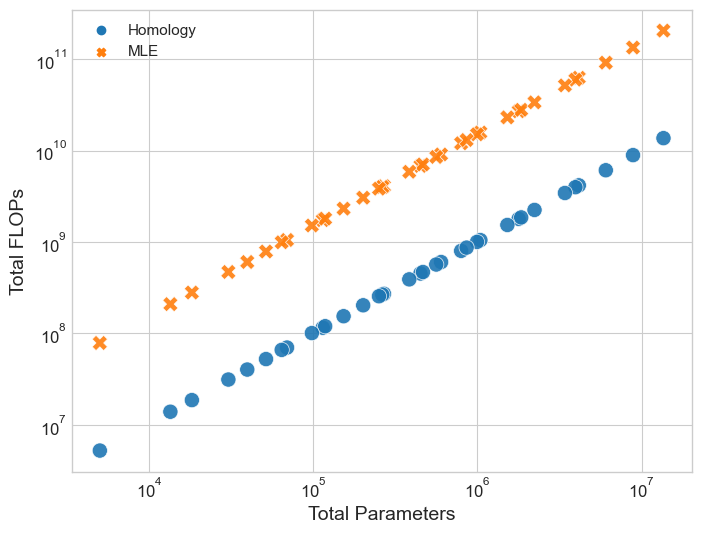

Saved 'time_vs_params.pdf'


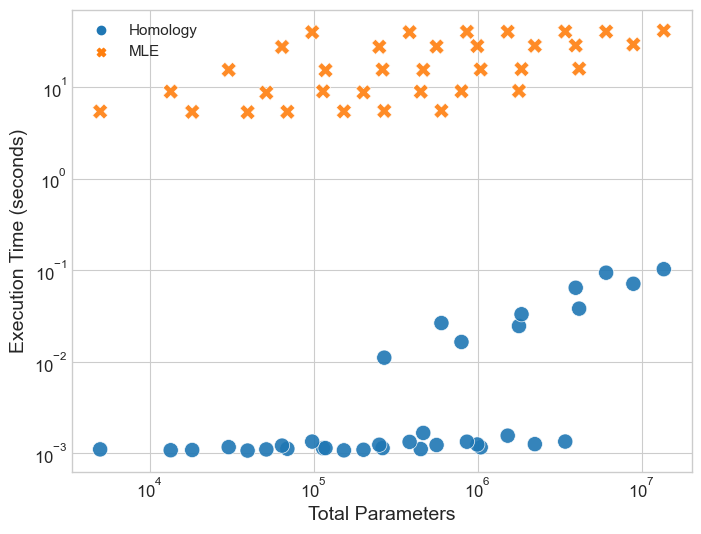

In [51]:
plot_scalability_for_latex(results_df)